In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# constants
BATCH_SIZE = 2048
target_mean = 0.5 # for normalizing image data
target_std = 0.5 # for normalizing image data
ENCODING_SIZE = 32

## Load data

In [3]:
initial_transform = transforms.Compose([transforms.ToTensor(),])
initial_dataset = datasets.MNIST(root='./data', train=True, transform=initial_transform, download=True)
initial_loader = torch.utils.data.DataLoader(initial_dataset, batch_size=len(initial_dataset))

In [4]:
data = next(iter(initial_loader))[0] # gets the entire dataset
current_mean = data.mean().item()
current_std = data.std().item()

In [5]:
print(f"{data.shape = }")
print(f"{current_mean = }")
print(f"{current_std = }")

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.13066047430038452
current_std = 0.30810782313346863


In [6]:
transform_mean = (current_mean * target_std - target_mean * current_std) / target_std
transform_std = current_std / target_std

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((transform_mean,), (transform_std,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# test statistics (make sure mean and median are 0.5 and 0.5)
statistics_test_loader = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
statistics_test_loader = torch.utils.data.DataLoader(statistics_test_loader, batch_size=len(statistics_test_loader))
data = next(iter(statistics_test_loader))[0] # gets the normalized entire dataset
current_mean = data.mean().item()
current_std = data.std().item()
print(f"{data.shape = }")
print(f"{current_mean = }") # confirm mean ~0.5
print(f"{current_std = }")  # confirm std  ~0.5

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.4999999701976776
current_std = 0.4999999701976776


## Training

In [36]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        mask_bottom = torch.zeros(32, requires_grad=False)
        mask_bottom[:16] = 1
        self.mask_bottom = mask_bottom
        
        mask_top = torch.zeros(32, requires_grad=False)
        mask_top[16:] = 1
        self.mask_top = mask_top
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, ENCODING_SIZE)
        )
        self.decoder = nn.Sequential(
            nn.Linear(ENCODING_SIZE, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )
        self.top_certificate = nn.Sequential(
            nn.Linear(ENCODING_SIZE//2, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )
        self.bottom_certificate = nn.Sequential(
            nn.Linear(ENCODING_SIZE//2, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )

    def forward(self, x, y):
        encoding = self.encoder(x)
        
        top_masks = y > 4
        bottom_masks = y < 4
        
        all_masks = torch.zeros(encoding.shape, requires_grad=False)
        all_masks[top_masks] = self.mask_top
        all_masks[bottom_masks] = self.mask_bottom
        all_masks = all_masks.to(device)

        masked_encoding = all_masks * encoding + (1 - all_masks) * encoding.detach()
        encoding_top = (masked_encoding[:,ENCODING_SIZE//2:]).detach()
        encoding_bottom = (masked_encoding[:,:ENCODING_SIZE//2]).detach()
        
        top_cert = self.top_certificate(encoding_top)
        bottom_cert = self.bottom_certificate(encoding_bottom)
        logits = self.decoder(masked_encoding)
        return encoding, logits, top_cert, bottom_cert

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=False)
  )
  (top_certificate): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=False)
  )
  (bottom_certificate): Sequential(
    (0): Linear(in_features=16, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_f

In [38]:
l1_loss = nn.L1Loss()
def loss_fn(X, X_hat, X_hat_top_cert, X_hat_bottom_cert, encoding, lambda_term=0.003, gamma=0.01):
    # Mean absolute error for reconstruction
    mae_top_cert = l1_loss(X, X_hat_top_cert)
    mae_bottom_cert = l1_loss(X, X_hat_bottom_cert)
    decoder_mae = l1_loss(X, X_hat)
    mae_reconstruction = decoder_mae + mae_top_cert + mae_bottom_cert
    
    # L1 norm for encoding
    encoding_loss = torch.norm(encoding, p=1) * lambda_term * (1/BATCH_SIZE)
    total_loss = mae_reconstruction + encoding_loss
    
    return decoder_mae, encoding_loss, mae_top_cert, mae_bottom_cert, total_loss

In [39]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)

In [40]:
def train(data_loader, loss, optimizer, model, epochs=1):
    model.train()
    train_loss_statistics = []
    decoder_maes = []
    encoding_losses = []
    mae_top_certs_loss = []
    mae_bottom_certs_loss = []
    
    for epoch in range(epochs):
        for batch_idx, data in enumerate(data_loader):
            X, y = data
            X = torch.flatten(X, start_dim=1).to(device)
            encoding, X_hat, X_hat_top_cert, X_hat_bottom_cert = model.forward(X, y)

            decoder_mae, encoding_loss, mae_top_cert, mae_bottom_cert, batch_loss = loss(X, X_hat, X_hat_top_cert, X_hat_bottom_cert, encoding)
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_statistics.append(batch_loss.item())
            decoder_maes.append(decoder_mae.item())
            encoding_losses.append(encoding_loss.item())
            mae_top_certs_loss.append(mae_top_cert.item())
            mae_bottom_certs_loss.append(mae_bottom_cert.item())
            
            current_batch = len(data_loader)*epoch + batch_idx
            if current_batch % 500 == 0:
                print(f"batch #{len(data_loader)*epoch + batch_idx}:\t {batch_loss:.4}")
                print(f"decoder:\t {decoder_mae:.4}")
                print(f"Top cert loss:\t {mae_top_cert:.4}")
                print(F"L1 loss:\t {encoding_loss:.4}")
                print("-------------------\n")
                
    return decoder_maes, encoding_losses, mae_top_certs_loss, mae_bottom_certs_loss, train_loss_statistics

In [41]:
train_rv = train(train_loader, loss_fn, optimizer, model, epochs=200)

batch #0:	 1.503
decoder:	 0.4985
Top cert loss:	 0.4996
L1 loss:	 0.005709
-------------------

batch #500:	 0.6143
decoder:	 0.2041
Top cert loss:	 0.2048
L1 loss:	 0.0001004
-------------------

batch #1000:	 0.5468
decoder:	 0.174
Top cert loss:	 0.1909
L1 loss:	 0.001165
-------------------

batch #1500:	 0.5314
decoder:	 0.1679
Top cert loss:	 0.1807
L1 loss:	 0.001102
-------------------

batch #2000:	 0.5034
decoder:	 0.1525
Top cert loss:	 0.1775
L1 loss:	 0.001716
-------------------

batch #2500:	 0.4868
decoder:	 0.1428
Top cert loss:	 0.1791
L1 loss:	 0.002395
-------------------

batch #3000:	 0.4733
decoder:	 0.1375
Top cert loss:	 0.1754
L1 loss:	 0.002758
-------------------

batch #3500:	 0.4723
decoder:	 0.1369
Top cert loss:	 0.1749
L1 loss:	 0.002862
-------------------

batch #4000:	 0.4696
decoder:	 0.1355
Top cert loss:	 0.1727
L1 loss:	 0.003028
-------------------

batch #4500:	 0.4673
decoder:	 0.134
Top cert loss:	 0.1723
L1 loss:	 0.003251
-----------------

In [43]:
decoder_maes, encoding_losses, mae_top_certs_loss, mae_bottom_certs_loss, train_loss_statistics = train_rv

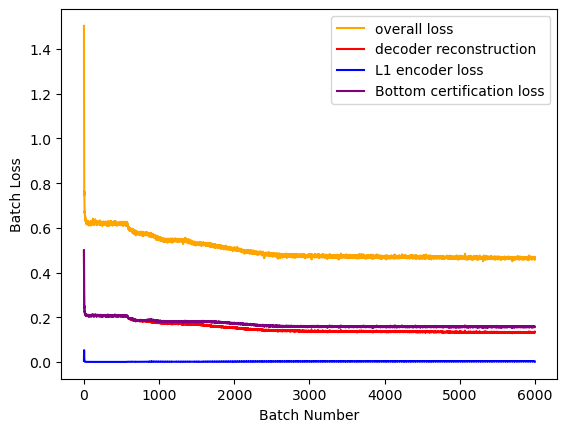

In [44]:
plt.plot(np.arange(0, len(train_loss_statistics)), train_loss_statistics, color='orange', label="overall loss")
plt.plot(np.arange(0, len(train_loss_statistics)), decoder_maes, color='red', label="decoder reconstruction")
plt.plot(np.arange(0, len(train_loss_statistics)), encoding_losses, color='blue', label="L1 encoder loss")
plt.plot(np.arange(0, len(train_loss_statistics)), mae_bottom_certs_loss, color='purple', label="Bottom certification loss")

plt.xlabel("Batch Number")
plt.ylabel("Batch Loss")
plt.legend()
plt.show()

## Testing Certificates

In [57]:
test_images_batch, test_labels_batch = next(iter(test_loader))

In [58]:
encoding, X_hat, X_hat_top_cert, X_hat_bottom_cert = model.forward(
    torch.flatten(test_images_batch, start_dim=1).to(device),
    test_labels_batch.to(device)
)

In [59]:
X_hat_top_cert.shape

torch.Size([2048, 784])

In [60]:
low_digits = torch.flatten(test_images_batch[test_labels_batch < 4,...], start_dim=1)
high_digits = torch.flatten(test_images_batch[test_labels_batch > 4,...], start_dim=1)
bottom_cert_low_digits = X_hat_top_cert[test_labels_batch < 4,:].to('cpu')
bottom_cert_high_digits = X_hat_top_cert[test_labels_batch > 4,:].to('cpu')
low_digits_loss = l1_loss(low_digits, bottom_cert_low_digits)
high_digits_loss = l1_loss(high_digits, bottom_cert_high_digits)

In [61]:
low_digits_loss, high_digits_loss

(tensor(0.1818, grad_fn=<MeanBackward0>),
 tensor(0.1511, grad_fn=<MeanBackward0>))

## Saving Model

In [304]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 200,
    'loss': 0.06390269100666046
}, "200_epochs_with_certs/model.pth")

## Generating Image Samples

In [62]:
# test_images_batch, test_labels_batch = next(iter(test_loader))

In [97]:
# get reconstructed images
# _encodings, reconstructed_test_imgs, _top_cert, _bottom_cert = model.forward(torch.flatten(test_images_batch, start_dim=1).to(device),test_labels_batch.to(device))
reconstructed_test_imgs_high = X_hat_top_cert[test_labels_batch > 4].detach().to('cpu').view(-1, 28, 28)
reconstructed_test_imgs_low = X_hat_top_cert[test_labels_batch < 4].detach().to('cpu').view(-1, 28, 28)
test_images_batch_high = test_images_batch[test_labels_batch > 4]
test_images_batch_low = test_images_batch[test_labels_batch < 4]
reconstructed_test_imgs = reconstructed_test_imgs.view(-1, 28, 28)
reconstructed_test_imgs= reconstructed_test_imgs.cpu().detach()

In [98]:
# _encodings.shape

In [99]:
# reconstructed_test_imgs_high

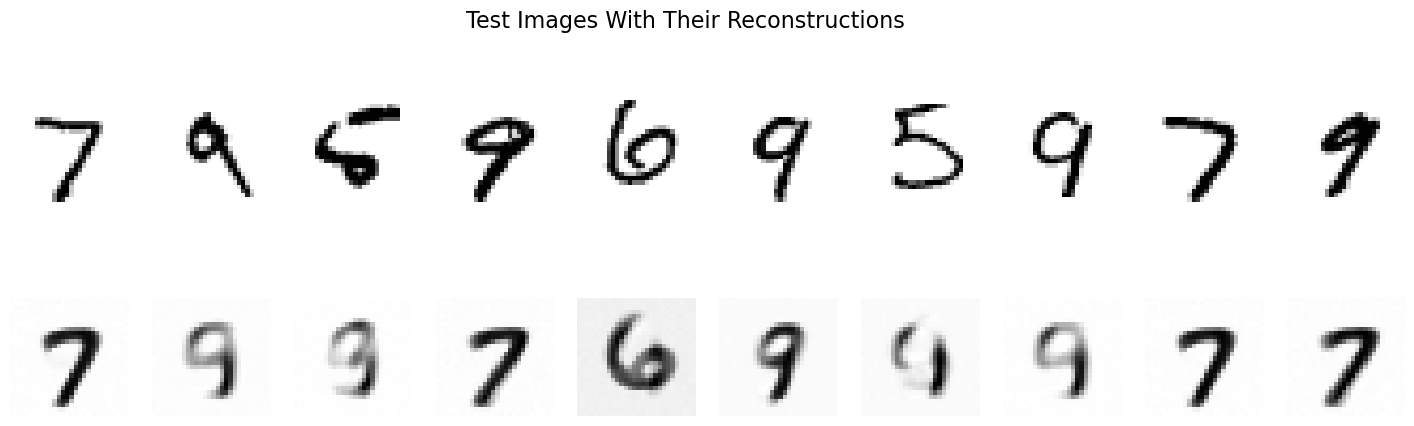

In [100]:
columns = 10
rows = 2
fig, axes = plt.subplots(rows, columns, figsize=(18, 5))
for i, ax in enumerate(axes.flat):
    if i >= columns:
        ax.imshow(reconstructed_test_imgs_high[i - columns]* -1, cmap='gray')
    else:
        ax.imshow(test_images_batch_high[i].squeeze()* -1, cmap='gray')
    ax.axis('off')
fig.suptitle('Test Images With Their Reconstructions', fontsize=16)
plt.savefig('200_epochs_with_certs/image_reconstructions.png', dpi=300)
plt.show()

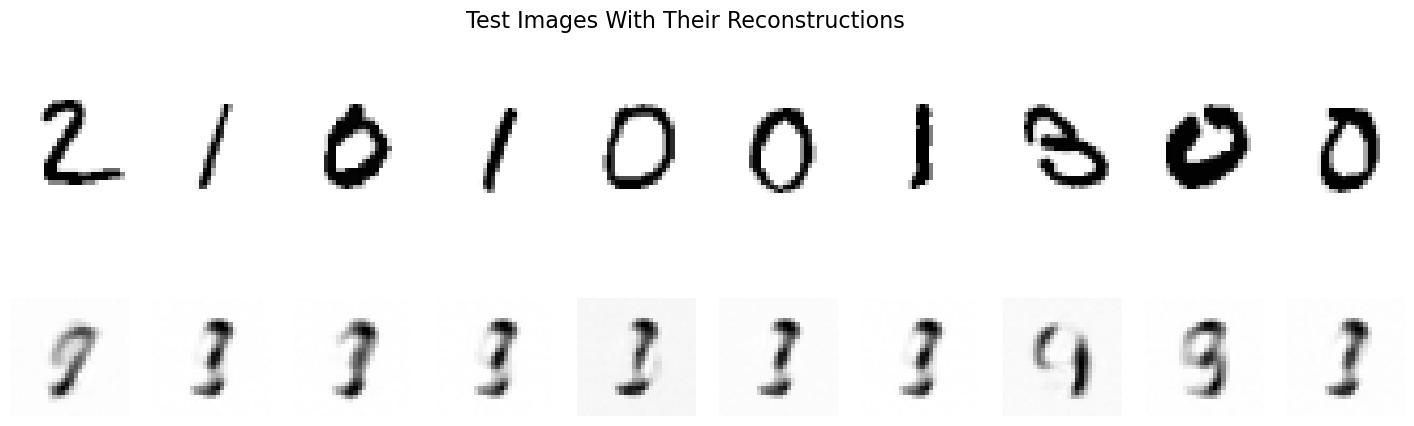

In [101]:
columns = 10
rows = 2
fig, axes = plt.subplots(rows, columns, figsize=(18, 5))
for i, ax in enumerate(axes.flat):
    if i >= columns:
        ax.imshow(reconstructed_test_imgs_low[i - columns]* -1, cmap='gray')
    else:
        ax.imshow(test_images_batch_low[i].squeeze()* -1, cmap='gray')
    ax.axis('off')
fig.suptitle('Test Images With Their Reconstructions', fontsize=16)
plt.savefig('200_epochs_with_certs/image_reconstructions.png', dpi=300)
plt.show()